# Pump It Up Challenge
## Tarea Machine Learning - Máster en Data Science, Big Data & Business Intelligence
### Fabio Ovidio Bianchini Cano

# <span style="color:DarkTurquoise">Modelado</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from custom_functions import confusion_matrix_plotter, feature_importances, decode_list

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
import shap

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Leemos los dataframes que hemos utilizado hasta ahora
train_labels = pd.read_csv('train-labels.csv')
train_values = pd.read_csv('train-values.csv', parse_dates = ['date_recorded' ],  na_values = [0, '0'])
test_values = pd.read_csv('test-values.csv', parse_dates = ['date_recorded' ] , na_values = [0, '0'])
processed_df = pd.read_csv('processed_df.csv')

In [3]:
# Separamos del dataframe preprocesado la parte de train de la de test
train_set = processed_df [processed_df ["id"].isin(train_values["id"])]
test_set = processed_df [processed_df ["id"].isin(test_values["id"])]

In [4]:
# Subdividimos train para entrenar el modelo
X = train_set.drop(['id', 'status_group'], axis=1)
y = train_set['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 , stratify = y)

## Resumen del modelo

Definiremos una lista de modelos y los entrenaremos todos para comparar qué tal predice en este caso concreto.

El código que está abajo es el código que calcula aproximadamente la precisión de cada modelo para compararlos entre sí y elegir los mejores. Sin embargo es un código muy lento de ejecutar en Jupyter Notebook, por lo tanto las pruebas se hicieron en local, el dataframe de resultado es el proporcionado por este código sin haberse ejecutado aquí.

In [5]:
# # Definimos los modelos
# models = [LogisticRegression(max_iter = 1000000,  random_state=42),
#     KNeighborsClassifier(),
#     DecisionTreeClassifier( random_state=42),
#     RandomForestClassifier( random_state=42),
#     XGBClassifier( random_state=42),
#     BaggingClassifier( random_state=42), 
#     AdaBoostClassifier( random_state=42),
#     GradientBoostingClassifier( random_state=42),
#     CatBoostClassifier( random_state=42)]

# # Lista de los nombres de los modelos
# names =['Logistic Regression', 'KNN Classifier', 'Decision Tree Classifier', 'Random Forest Classifier',  'XGB Classifier', 
#         'Bagging Classifier', 'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Catboost Classifier']

# # Listas de predicción y desviación típica
# accuracy = []
# std = []

# # 10 validaciones cruzadas de cada modelo, los resultados se añaden a cada lista.
# for model in models:
#   cv = KFold(n_splits = 10, shuffle = True,  random_state = 1)
#   n_scores = cross_val_score(model, X, y, scoring='accuracy', cv = cv, n_jobs = -1, error_score = 'raise')
#   mean_score = np.mean(n_scores)
#   std_score = np.std(n_scores)
#   accuracy.append(mean_score)
#   std.append(std_score)

# # Creación del dataframe final
# d = {'Model': names,'Accuracy': accuracy, 'Std': std}   
# score_df = pd.DataFrame(d)
# score_df

# Todo el código de arriba se ha ejecutado y guardado en best_models.csv, esto está simplemente para leerse más fácilmente.
best_models = pd.read_csv("best_models.csv")
best_models

,model,accuracy,std
0,Logistic Regression,0.666510,0.006001
1,KNN Classifier,0.701140,0.007301
2,Decision Tree Classifier,0.756158,0.004169
3,Random Forest Classifier,0.804121,0.004219
4,XGB Classifier,0.742740,0.005622
5,Bagging Classifier,0.793599,0.003323
6,AdaBoost Classifier,0.723985,0.005083
7,Gradient Boosting Classifier,0.751174,0.005385
8,Catboost Classifier,0.796428,0.003599


#### Recordatorio
Vamos a elegir unos cuantos de los mejores modelos para hacer la predicción. Estos modelos los elegidos al hacer pruebas en local, ejecutarlos en Jupyter es muy lento, pero los resultados son los que están arriba.

## Random Forest

Accuracy score train: 0.9226204255140049
Accuracy score test: 0.8134680134680135

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.62      0.29      0.40       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.76      0.66      0.69     11880
           weighted avg       0.81      0.81      0.80     11880



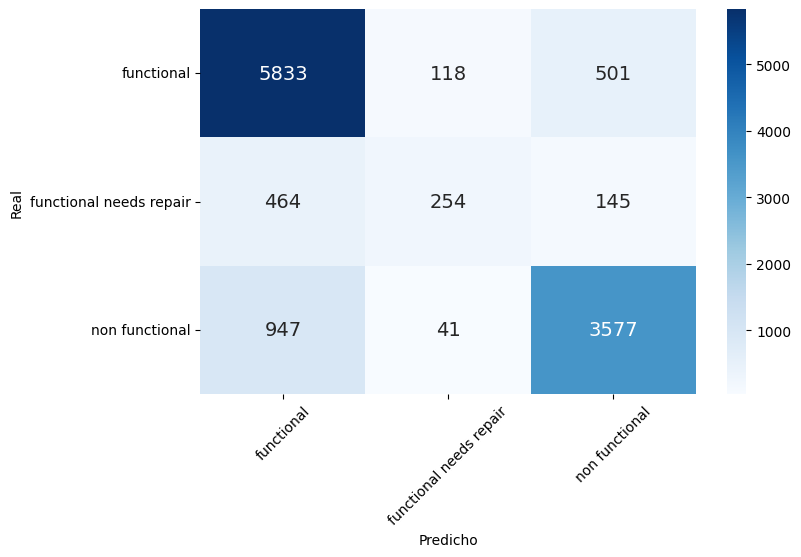

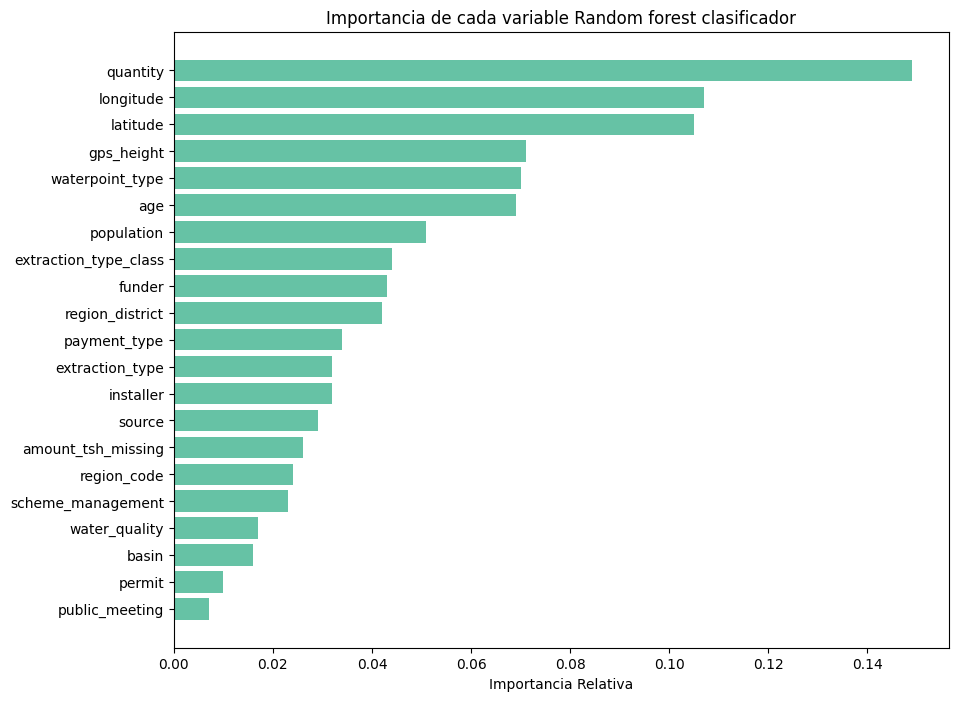

In [6]:
RF_model = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_split=7, n_estimators=225, random_state=42, warm_start=True)

# Entrenamiento y predicción
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)
y_pred_train = RF_model.predict(X_train)

print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

print(classification_report(y_test, y_pred))
confusion_matrix_plotter(y_test, y_pred)
feature_importances(X_train, RF_model, " Random forest clasificador")

Random Forest trabaja bien prediciendo correctamente las bombas funcionales, bastante peor prediciendo las no funcionales y equivocándose bastante en las que necesitan reparación.

Le da mucha importancia a la cantidad de agua en la bomba y a sus coordenadas. Variables que pensábamos que tendrían mucho peso como basin o amount_tsh_missing han acabado siendo poco importantes.

## XGBoost

In [7]:
# Codificamos la variable de clase (functional, non_functional y needs_repair) a 0, 1, 2 puesto que XGBoost necesita que se pase así
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Accuracy score train: 0.9438329931185421
Accuracy score test: 0.8103535353535354

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      6452
functional needs repair       0.58      0.30      0.40       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.74      0.66      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



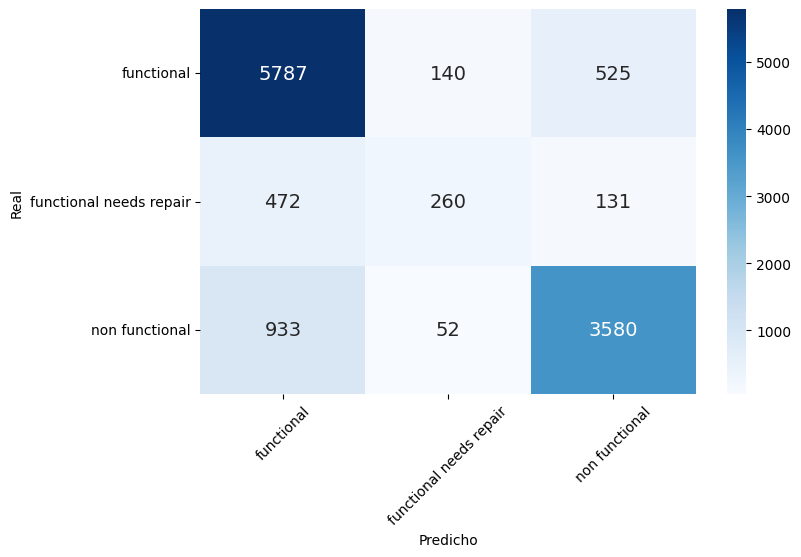

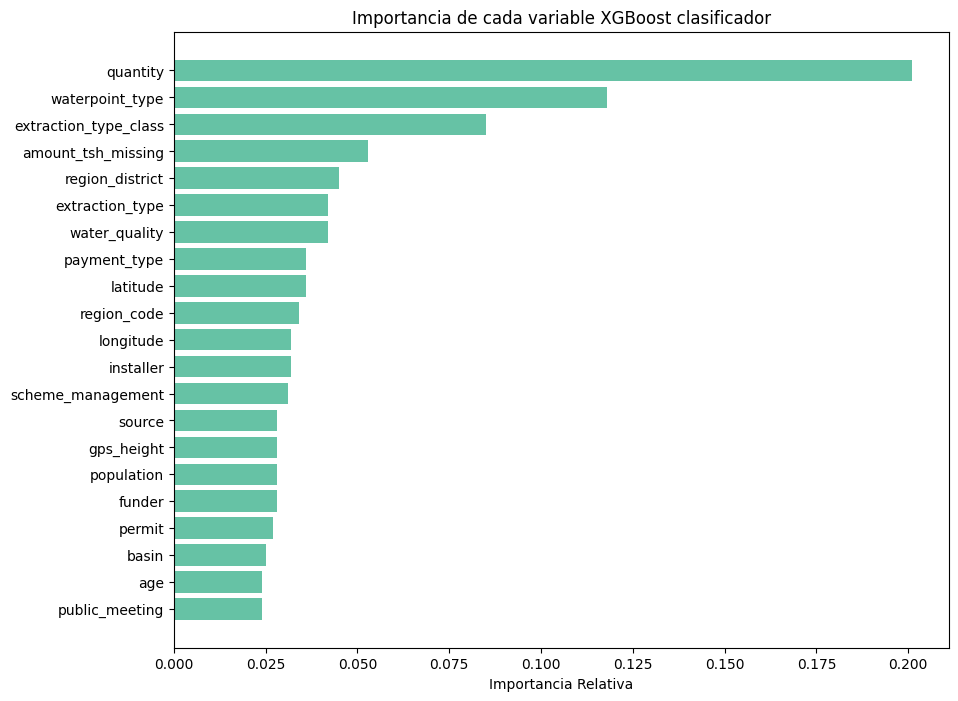

In [8]:
XGB_model = XGBClassifier( random_state=42, n_estimators = 200, colsample_bytree = 0.3, eta = 0.2, max_depth = 12, eval_metric = "mlogloss")

# Entrenamiento y predicción
XGB_model.fit(X_train, y_train_encoded)
y_pred = XGB_model.predict(X_test)
y_pred_train = XGB_model.predict(X_train)

# Volvemos a decodificar la lista, para poder imprimirla con los nombres originales
uniques = ["functional", "functional needs repair", "non functional"]
y_pred = decode_list(y_pred, uniques)
y_pred_train = decode_list(y_pred_train, uniques)

print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

print(classification_report(y_test, y_pred))
confusion_matrix_plotter(y_test, y_pred)
feature_importances(X_train, XGB_model, " XGBoost clasificador")

Resultados muy parecidos a Random Forest. No sorprende puesto que este algoritmo está también basado en árboles de decisión.

Lo que sí sorprende es la diferencia con respecto a las variables más importantes. Age pasa de ser de las más importantes en RF a ser la penúltima, a gps_height le pasa parecido. Quantity sigue liderando, pero esta vez a su vera están waterpoint_type y extraction_type. Al parecer se puede llegar a más o menos la misma conclusión utilizando diferentes variables.

## CatBoost

Accuracy score train: 0.8707674824806919
Accuracy score test: 0.805050505050505

                         precision    recall  f1-score   support

             functional       0.79      0.90      0.85      6452
functional needs repair       0.61      0.29      0.39       863
         non functional       0.84      0.76      0.80      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.65      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



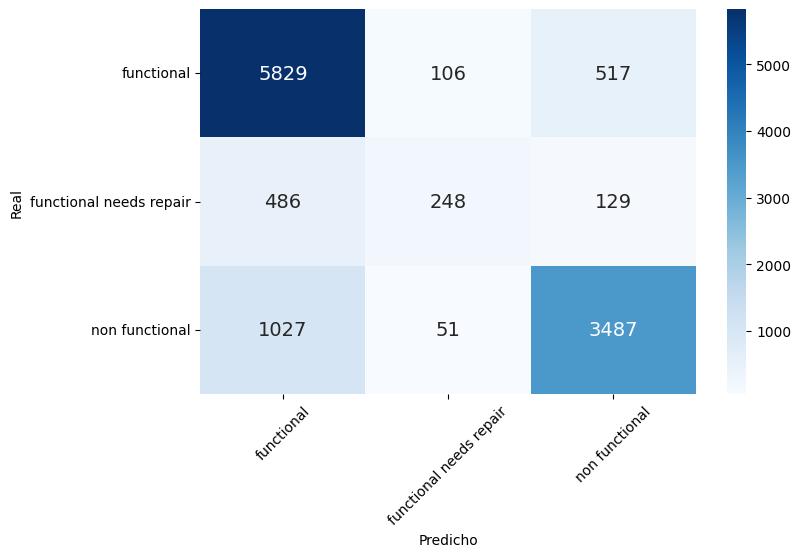

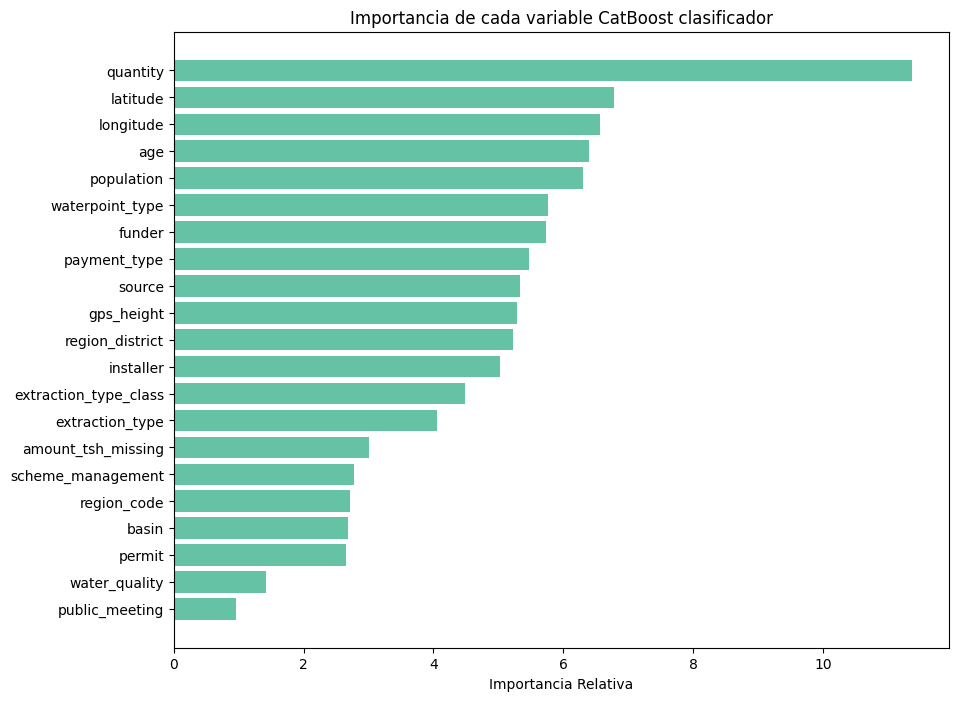

In [9]:
Cat_model = CatBoostClassifier( random_state=42, rsm = 0.2, max_depth =9, iterations = 1000, silent=True)

Cat_model.fit(X_train, y_train)
y_pred = Cat_model.predict(X_test)
y_pred_train = Cat_model.predict(X_train)

print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

print(classification_report(y_test, y_pred))
confusion_matrix_plotter(y_test, y_pred)
feature_importances(X_train, Cat_model, " CatBoost clasificador")

Resultados parecidos a los anteriores. Quantity sigue liderando, y las variables posteriores siguen siendo aproximadamente las mismas. La cola de las variables son siempre las mismas.

## Bagging

Accuracy score train: 0.9874997369473263
Accuracy score test: 0.8014309764309764

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      6452
functional needs repair       0.48      0.32      0.39       863
         non functional       0.83      0.79      0.81      4565

               accuracy                           0.80     11880
              macro avg       0.71      0.66      0.68     11880
           weighted avg       0.79      0.80      0.80     11880



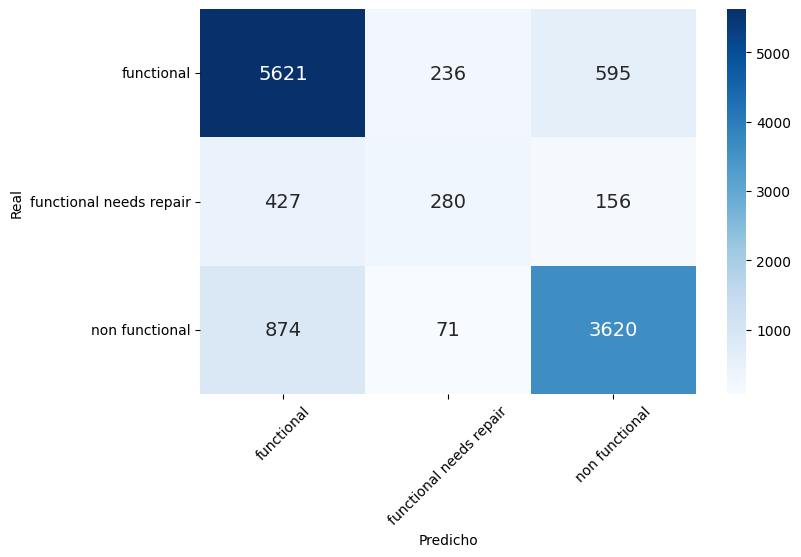

In [10]:
Bag_model = BaggingClassifier(random_state=42, n_estimators = 200, max_features = 1.0)

# Entrenamiento y predicción
Bag_model.fit(X_train, y_train)
y_pred = Bag_model.predict(X_test)
y_pred_train = Bag_model.predict(X_train)


print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

print(classification_report(y_test, y_pred))
confusion_matrix_plotter(y_test, y_pred)

De aquí no podemos sacar el peso de cada variable en los resultados finales directamente así que lo sacamos calculando la media de cada árbol de decisión.

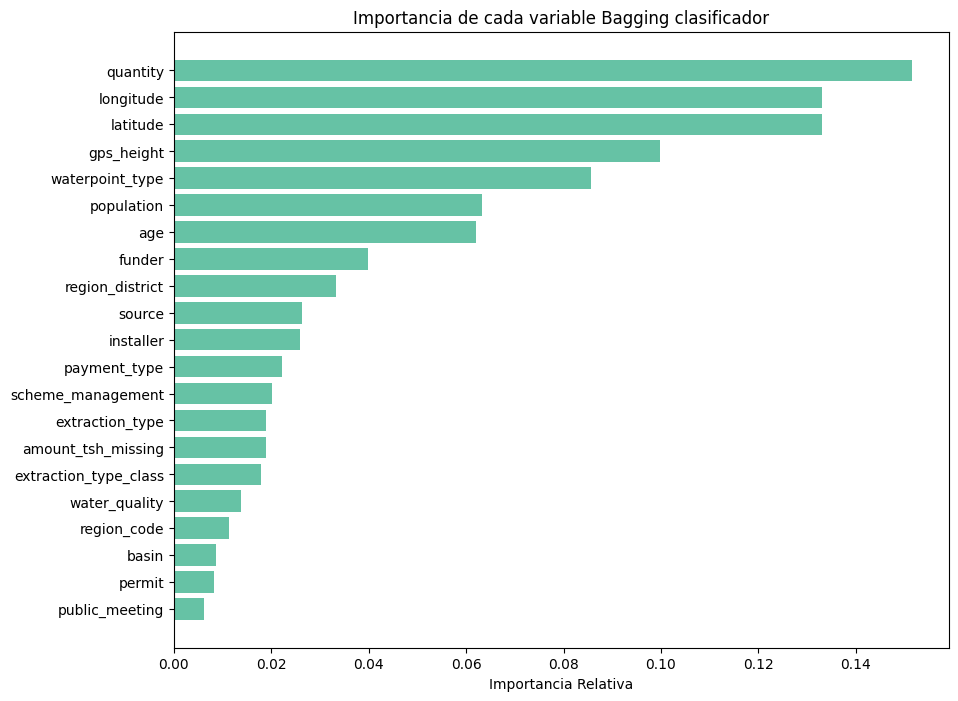

In [11]:
bagging_feature_importances = np.mean([tree.feature_importances_ for tree in Bag_model.estimators_], axis=0)
feature_importances(X_train, Bag_model, " Bagging clasificador", bagging_feature_importances)

Resultados muy similares al resto, nada destacable que decir de esta iteración.

# Resultados finales y conclusión

In [12]:
models = ['Random Forest Classifier', 'XgBoost Classifier', 'CatBoost Classifier', 'Bagging Classifier']
training_accuracy = [0.9226, 0.9438, 0.8707, 0.9874]
testing_accuracy = [0.8134, 0.8103, 0.8050, 0.8014]

score_df = pd.DataFrame({'Model':models,'Train accuracy':training_accuracy, 'Test accuracy':testing_accuracy})
score_df 

,Model,Train accuracy,Test accuracy
0,Random Forest Classifier,0.9226,0.8134
1,XgBoost Classifier,0.9438,0.8103
2,CatBoost Classifier,0.8707,0.8050
3,Bagging Classifier,0.9874,0.8014


Random Forest es muy ligeramente superior al resto, dándonos los mejores resultados, con un 0.8134 de precisión.

Vamos a utilizarlo para conseguir nuestro CSV de resultado.

In [15]:
result = test_set.drop(['id', 'status_group'], axis=1)
result["status_group"] = RF_model.predict(result)
result['id'] = test_set['id']
result = result[['id', 'status_group']]
result.head()    
# result.to_csv("result.csv", index=False)

,id,status_group
59399,50785,non functional
59400,51630,functional
59401,17168,functional
59402,45559,non functional
59403,49871,functional
